In [1]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 3.6 MB/s             


In [2]:
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import os
import json

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm
import random

Segmentation Models: using `keras` framework.


In [3]:
dict = {'classes' : ['Building','Land (unpaved area)','Road','Vegetation', 'Water','Unlabeled'],
        'colors' : ['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']}

patch_size = 256

In [4]:
def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        color = np.array([255 * x for x in to_rgb(col)]).astype('uint8')
        ref[np.all(label == color,axis=-1)] = i
    return ref

def patchify(img):
    m,n,b = img.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(img[i:i+patch_size,j:j+patch_size,:])
    return crops

def patchify_lab(label):
    m,n = label.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(label[i:i+patch_size,j:j+patch_size])
    return crops

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [5]:
folder = r"../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
tiles = os.listdir(folder)
train_set = []
train_lab = []
test_set = []
test_lab = []
for tile in tiles:
    if os.path.isdir(os.path.join(folder,tile)):
        files = os.listdir(os.path.join(folder,tile,'images'))
        for file in files:
            img = imageio.imread(os.path.join(folder,tile,'images',file))/255
            img = patchify(img)
            label = imageio.imread(os.path.join(folder,tile,'masks',file[:-3] + 'png'))
            label = labelize(label)
            label = patchify_lab(label)

            if file == 'image_part_009.jpg':
                test_set = test_set + img
                test_lab = test_lab + label
            else:
                train_set = train_set + img
                train_lab = train_lab + label
                
train_set = np.array(train_set)  
test_set = np.array(test_set)  
train_lab = np.array(train_lab) 
n_classes = len(np.unique(train_lab)) 
train_lab = to_categorical(train_lab, num_classes=n_classes)
test_lab = np.array(test_lab)  
test_lab = to_categorical(test_lab, num_classes=n_classes)
print(train_set.shape)
print(test_set.shape)
print(train_lab.shape)
print(test_lab.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


(1160, 256, 256, 3)
(145, 256, 256, 3)
(1160, 256, 256, 6)
(145, 256, 256, 6)


In [6]:
def unet_model(n_classes=n_classes, IMG_HEIGHT=patch_size, IMG_WIDTH=patch_size, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
metrics=['accuracy', jaccard_coef]
loss = sm.losses.DiceLoss() 
model= unet_model()
model.summary()
model.compile(optimizer='adam', loss=loss, metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_set, train_lab, test_size = 0.20, random_state = 42)

In [10]:
history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=35, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/35
116/116 [==============================] - 16s 58ms/step - loss: 0.6973 - accuracy: 0.5582 - jaccard_coef: 0.3865 - val_loss: 0.5991 - val_accuracy: 0.6785 - val_jaccard_coef: 0.5266
Epoch 2/35
116/116 [==============================] - 5s 45ms/step - loss: 0.5987 - accuracy: 0.6480 - jaccard_coef: 0.4820 - val_loss: 0.5698 - val_accuracy: 0.6966 - val_jaccard_coef: 0.5481
Epoch 3/35
116/116 [==============================] - 5s 45ms/step - loss: 0.5470 - accuracy: 0.6897 - jaccard_coef: 0.5287 - val_loss: 0.6144 - val_accuracy: 0.6916 - val_jaccard_coef: 0.5432
Epoch 4/35
116/116 [==============================] - 5s 45ms/step - loss: 0.5266 - accuracy: 0.7096 - jaccard_coef: 0.5542 - val_loss: 0.5028 - val_accuracy: 0.7375 - val_jaccard_coef: 0.5973
Epoch 5/35
116/116 [==============================] - 5s 45ms/step - loss: 0.4774 - accuracy: 0.7483 - jaccard_coef: 0.6030 - val_loss: 0.4552 - val_accuracy: 0.7727 - val_jaccard_coef: 0.6418
Epoch 6/35
116/116 [==============

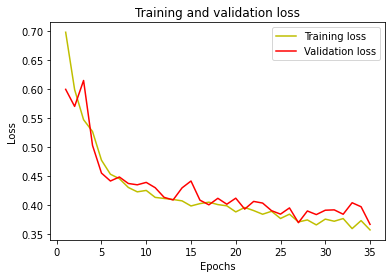

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

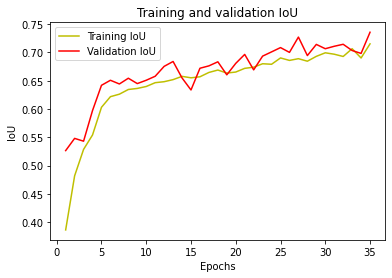

In [12]:
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [13]:
y_pred=model.predict(test_set)
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)

IoU = 0.769659698009491


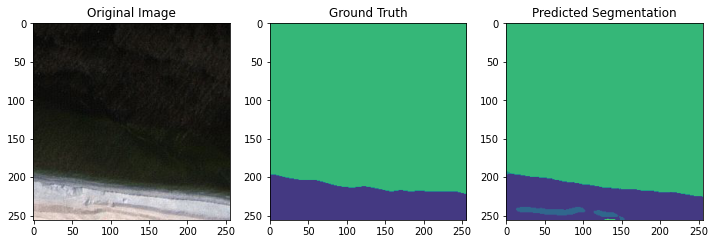

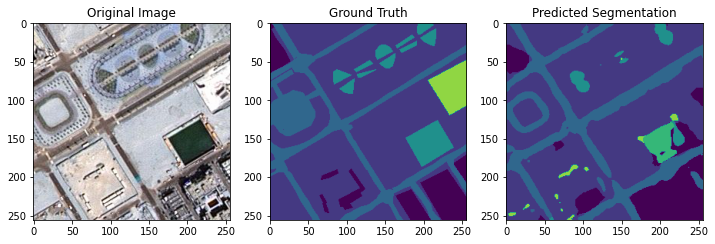

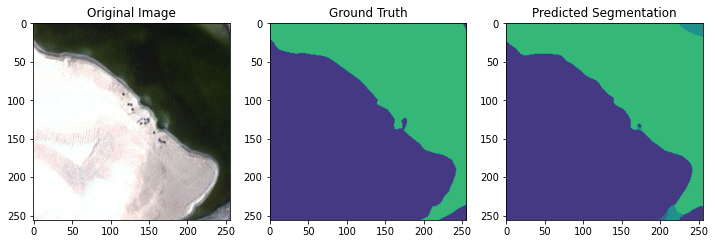

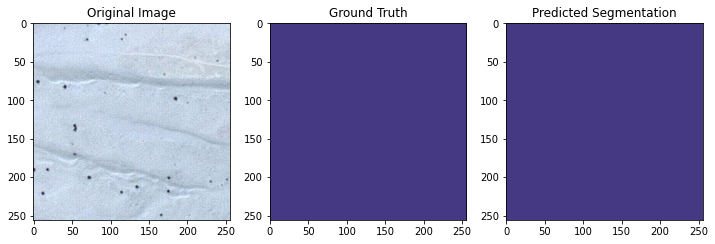

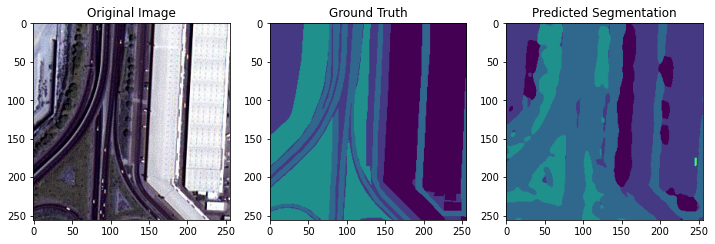

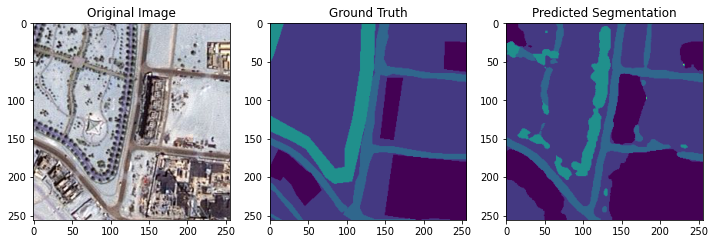

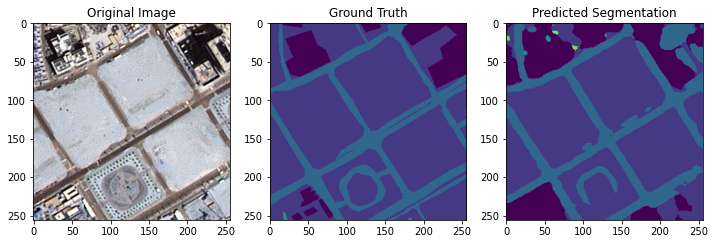

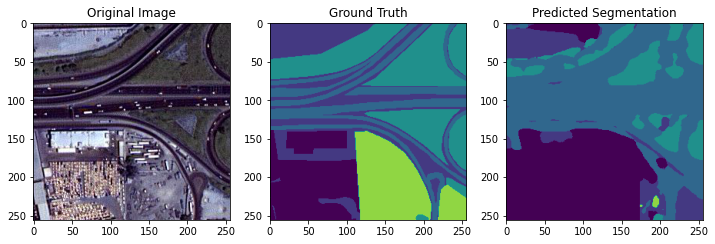

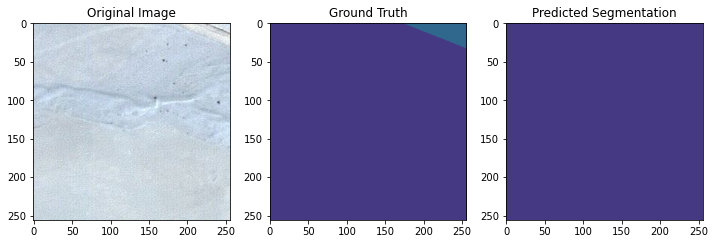

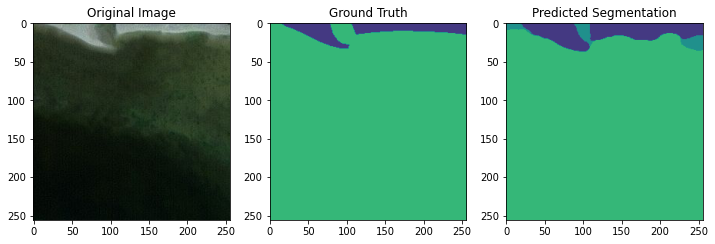

In [15]:
num_samples = 10
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Original Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Ground Truth')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Predicted Segmentation')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()